In [65]:
import os
from pymystem3 import Mystem
mystem = Mystem()
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
import nltk
from nltk.corpus import stopwords
import os
import math
import pandas as pd
from functools import reduce
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
authors_list = [name for name in os.listdir('archive')]
authors_list

['Blok',
 'Chekhov',
 'Dostoevsky',
 'Gogol',
 'Gorky',
 'Pushkin',
 'Tolstoy',
 'Turgenev']

In [3]:
home_path = os.getcwd()

author_text_dict = {}
total_texts = []

for name in authors_list:
    texts_by_author = []
    os.chdir(home_path)
    os.chdir('archive\\'+name)
    for file in os.listdir():
        text = open(file, 'r', encoding='utf-8').read()
        texts_by_author.append(text)
        total_texts.append(text)
    author_text_dict[name] = texts_by_author

In [4]:
def preprocessor(text):
    '''Text preprocessing function using regular expressions.
    Cleaning the text from the names of the authors, chapter numbers,
    Roman numbers, page numbers, footnotes, and punctuation. 
    Lowercasing the text.'''
    import re
    text = text.replace("Лев Николаевич Толстой", " ").replace("Лев Толстой", " ").replace("Часть первая", " ").\
        replace("Часть вторая", " ").replace("Часть третья", " ").replace("Часть четвертая", " ").\
        replace("ЧАСТЬ ПЕРВАЯ", " ").replace("ЧАСТЬ ВТОРАЯ", " ").replace("ЧАСТЬ ТРЕТЬЯ", " ").\
        replace("ЧАСТЬ ЧЕТВЕРТАЯ", " ").replace("Антон Чехов", " ").replace("Примечания", " ").\
        replace("Николай Гоголь", " ").replace("Николай Васильевич Гоголь", " ").replace("Максим Горький", " ").\
        replace("М. ГОРЬКИЙ", " ").replace("Александр Сергеевич Пушкин", " ").replace("Александр Пушкин", " ").\
        replace("Иван Сергеевич Тургенев", " ").replace("Иван Тургенев", " ").replace("Федор Михайлович Достоевский", " ")
        
    text = re.sub(r"(Глава|ГЛАВА|Том|ТОМ) \S+", " ", text)
    text = re.sub(r"--+", "-", text)
    text = re.sub(r"\**\[.*\]", " ", text)
    text = re.sub(r"\[.*\]", " ", text)
    text = re.sub(r"{.*}", " ", text)
    text = re.sub(r"Стр\..+\n", " ", text)
    text = re.sub(r"[IVXL]+", " ", text)
    text = re.sub(r" - ", " ", text)
    text = re.sub(r"[А-Я]\. *[А-Я]\. [А-Я]\S+", " ", text)
    text = re.sub(r"<<.+>>", " ", text)
    text = re.sub(r"[!@#$%\^\&\*()_=+\?\!:;\",\.»«—]", " ", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\s\s*", " ", text)
    text = text.lower()
    return text


In [5]:
clean_author_text_dict = {}
clean_total_texts = []

for author in author_text_dict:
    clean_texts_by_author = []
    for text in author_text_dict[author]:
        clean_text = preprocessor(text)
        clean_texts_by_author.append(clean_text)
        clean_total_texts.append(clean_text)
    clean_author_text_dict[author] = clean_texts_by_author

In [14]:
stops = set(stopwords.words('russian') + ["этот", "весь", "свой", "мой", "наш", "их", "ее", "его", "ваш", "твой", "каждый", \
                                          "который", "первый", "второй", "третий", "четвертый", "пятый", "шестой",\
                                         "седьмой", "восьмой", "девятый", "десятый", "какой", "некоторый", "какой-то", "сей",\
                                         "св", "последний", "самый", "всякий", "этакий", "эдакий"])

In [44]:
# Функция для вычисления того, сколько раз биграмма встречается в отдельном токенизированном документе, выдает словарь {биграмма: кол-во появлений}

def bigram_freq_one_doc(tokenized_text):
  bigram_freq_dict = {}
  text_length = len(tokenized_text)
  for i in range(text_length-1):
      if morph.parse(tokenized_text[i])[0].tag.POS == "ADJF" and morph.parse(tokenized_text[i])[0].normal_form not in stops \
              and morph.parse(tokenized_text[i+1])[0].tag.POS == "NOUN" and morph.parse(tokenized_text[i+1])[0].normal_form not in stops:
          bigram = (morph.parse(tokenized_text[i])[0].normal_form, morph.parse(tokenized_text[i + 1])[0].normal_form)
          if bigram not in bigram_freq_dict:
              bigram_freq_dict[bigram] = 0
          bigram_freq_dict[bigram] += 1

  return bigram_freq_dict

# Функция вычисления того, в скольких документах биграмма встречается, принимает список словарей из предыдущей функции по каждому доку

def bigram_doc(bigram_freq_dicts):
    bigram_doc_counter = {}
    for bigram_dict in bigram_freq_dicts:
        for bigram in bigram_dict:
            if bigram not in bigram_doc_counter:
                bigram_doc_counter[bigram] = 0
            bigram_doc_counter[bigram] += 1

    return bigram_doc_counter

# Функция сливания словарей биграмм для каждого отдельного документа в один словарь с суммированием частот появления биграмм 

def merge_bigram_freq_dicts(bigram_freq_dicts):
    merged_bigram_freq_dict = {}
    for bigram_dict in bigram_freq_dicts:
        for bigram in bigram_dict.keys():
            merged_bigram_freq_dict[bigram] = merged_bigram_freq_dict.get(bigram, 0) + bigram_dict[bigram]

    return merged_bigram_freq_dict

# Функция для вычисления tf биграмм относительно длины текста

def bigram_tf(merged_bigram_freq_dict, text_length):
    bigram_tf_dict = {}
    for bigram in merged_bigram_freq_dict:
        tf_bigram = merged_bigram_freq_dict[bigram] / text_length
        bigram_tf_dict[bigram] = tf_bigram
    return bigram_tf_dict

# Функция для вычисления idf

def bigram_idf(bigram_doc_counter, num_docs):
    bigram_idf_dict = {}
    for bigram in bigram_doc_counter:
        bigram_idf_dict[bigram] = math.log(num_docs / bigram_doc_counter[bigram])
    return bigram_idf_dict

# Функция, которая объединяет все предыдущие и вычисляет tf * idf для каждой биграммы

def make_bigram_tfidf_dict(clean_author_text_dict):
    bigram_tfidf_by_author = {}
    num_docs = reduce(lambda x,y: x + len(y), list(clean_author_text_dict.values()), 0)
    for author in clean_author_text_dict:
        text_length = len((' '.join(clean_author_text_dict[author])).split())
        bigram_freq_dicts = [bigram_freq_one_doc(text.split()) for text in clean_author_text_dict[author]]
        bigram_doc_counter = bigram_doc(bigram_freq_dicts)
        merged_bigram_freq_dict = merge_bigram_freq_dicts(bigram_freq_dicts)
        bigram_tf_dict = bigram_tf(merged_bigram_freq_dict, text_length)
        bigram_idf_dict = bigram_idf(bigram_doc_counter, num_docs)
        bigram_tfidf = {bigram: bigram_tf_dict[bigram] * bigram_idf_dict[bigram] for bigram in set(bigram_tf_dict)}
        bigram_tfidf = dict(sorted(bigram_tfidf.items(), key=lambda x:x[1], reverse=True))
        bigram_tfidf_by_author[author] = bigram_tfidf
    
    return bigram_tfidf_by_author

    

In [62]:
bigram_tfidf_by_author = make_bigram_tfidf_dict(clean_author_text_dict)
bigram_tfidf_by_author

{'Blok': {('бессмертный', 'душа'): 0.0052926062562258175,
  ('муравьиный', 'царь'): 0.0052926062562258175,
  ('крайний', 'мера'): 0.0026463031281129088,
  ('розовый', 'калитка'): 0.0026463031281129088,
  ('безобразный', 'карлик'): 0.0026463031281129088,
  ('домовый', 'комитет'): 0.0026463031281129088,
  ('тусклый', 'солнце'): 0.001764202085408606,
  ('маленький', 'калитка'): 0.001764202085408606,
  ('соседний', 'мужик'): 0.001764202085408606,
  ('тайный', 'советник'): 0.001764202085408606,
  ('народный', 'просвещение'): 0.001764202085408606,
  ('зелёный', 'ров'): 0.001764202085408606,
  ('западный', 'легенда'): 0.001764202085408606,
  ('стриженый', 'липа'): 0.001764202085408606,
  ('тёмный', 'занавесь'): 0.001764202085408606,
  ('романтический', 'страна'): 0.001764202085408606,
  ('русский', 'человек'): 0.001764202085408606,
  ('вооружённый', 'гражданин'): 0.001764202085408606,
  ('долгий', 'жизнь'): 0.001764202085408606,
  ('золотой', 'змея'): 0.001764202085408606,
  ('бывший', 'вице-

In [63]:
phrase_tfidf_by_author = {}
for author in bigram_tfidf_by_author:
    phrase_tfidf = {}
    for bigram, tfidf in bigram_tfidf_by_author[author].items():
        noun = bigram[1]
        adj = bigram[0]
        try:
            gender = morph.parse(noun)[0].tag.gender    #gender of noun
            new_adj = morph.parse(adj)[0].inflect({gender, 'nomn'}).word
            new_value = new_adj + " " + noun
        except:
            new_value = adj + " " + noun
        phrase_tfidf[new_value] = tfidf
    phrase_tfidf_by_author[author] = phrase_tfidf
    
phrase_tfidf_by_author 

{'Blok': {'бессмертная душа': 0.0052926062562258175,
  'муравьиный царь': 0.0052926062562258175,
  'крайняя мера': 0.0026463031281129088,
  'розовая калитка': 0.0026463031281129088,
  'безобразный карлик': 0.0026463031281129088,
  'домовый комитет': 0.0026463031281129088,
  'тусклое солнце': 0.001764202085408606,
  'маленькая калитка': 0.001764202085408606,
  'соседний мужик': 0.001764202085408606,
  'тайный советник': 0.001764202085408606,
  'народное просвещение': 0.001764202085408606,
  'зелёный ров': 0.001764202085408606,
  'западная легенда': 0.001764202085408606,
  'стриженая липа': 0.001764202085408606,
  'тёмная занавесь': 0.001764202085408606,
  'романтическая страна': 0.001764202085408606,
  'русский человек': 0.001764202085408606,
  'вооружённый гражданин': 0.001764202085408606,
  'долгая жизнь': 0.001764202085408606,
  'золотая змея': 0.001764202085408606,
  'бывший вице-губернатор': 0.001764202085408606,
  'настоящий человек': 0.001764202085408606,
  'душный волос': 0.0008

In [66]:
def show_wordcloud(phrase_tfidf):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=800, height=400)
    wordcloud.generate_from_frequencies(frequencies=phrase_tfidf)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Blok


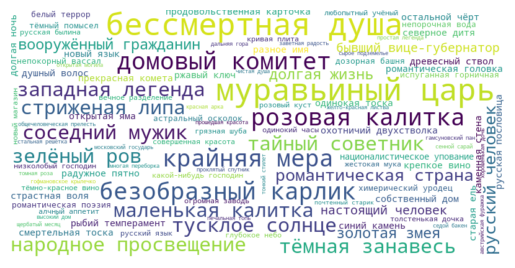

Chekhov


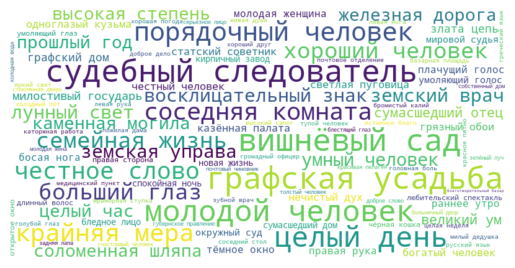

Dostoevsky


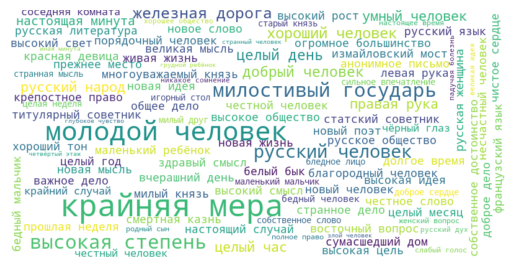

Gogol


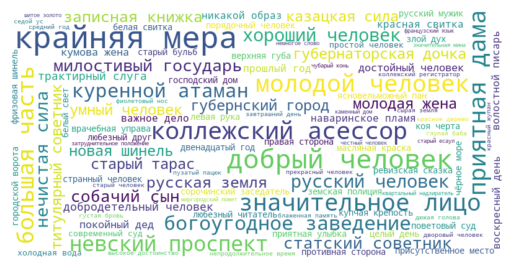

Gorky


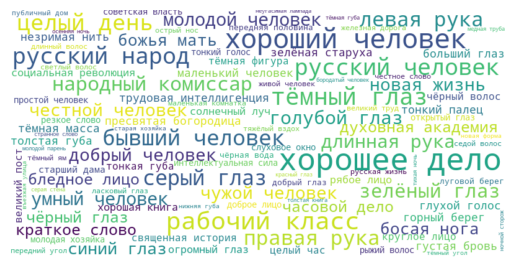

Pushkin


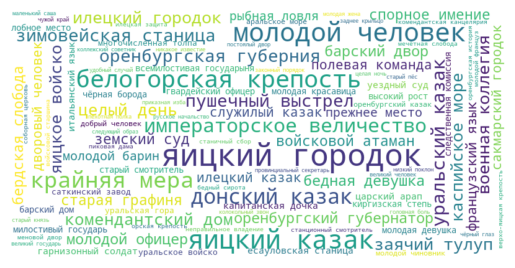

Tolstoy


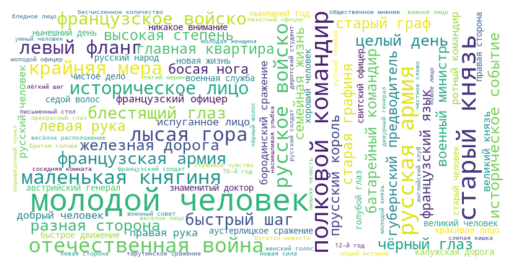

Turgenev


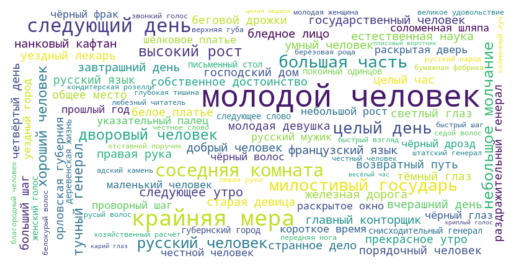

In [70]:
for author in phrase_tfidf_by_author:
    print(author)
    show_wordcloud(phrase_tfidf_by_author[author])